# Notebook 6.1 - Scheduling Mastery

Management Science - From Corporate Events to Rush Hours

# Introduction

Welcome to your role as **Bean Counter’s Operations Manager**! You’ve
been tasked with solving two critical scheduling challenges that will
determine the efficiency of your coffee empire:

**Challenge 1: The Corporate Event (Sections 1-4)**

A major tech company just ordered **20 specialty coffee drinks** for
their board meeting. All orders are known upfront with specific
deadlines. This is a **batch scheduling problem**, you have complete
information and need to sequence the orders optimally before starting
work.

**Challenge 2: The Friday Morning Rush (Sections 5-6)**

Every Friday, your flagship store faces a continuous stream of orders
arriving throughout the morning. You can’t see future orders and thus
you must make real-time decisions. This is an **online scheduling
problem** where orders reveal themselves over time.

These two scenarios represent fundamentally different scheduling
paradigms you’ll master today!

> **How to Use This Tutorial**
>
> Cells marked with “YOUR CODE BELOW” expect you to write code. Test
> your solutions with the provided assertions. Work through sections in
> order as each builds on previous concepts!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(2025)

print("Libraries loaded! Ready to optimize Bean Counter's operations.")

Libraries loaded! Ready to optimize Bean Counter's operations.

# Section 1 - The Corporate Event Problem

## The Scenario

TechCorp’s board meeting starts in 90 minutes. They’ve pre-ordered 20
specialty drinks with specific requirements. You have:

-   **Complete information**: All 20 orders known upfront
-   **One machine**: Must sequence orders optimally
-   **Varying complexity**: From simple espressos (3 min) to complex
    mochas (12 min)
-   **Deadlines**: Some executives need drinks early (rushed board
    members), others can wait (relaxed attendees)

This is **static scheduling** - you can plan the entire sequence before
starting.

## The Data Structure

Each order contains:

-   **Order ID**: Customer identifier
-   **Processing Time**: How long it takes to make
-   **Due Time**: When the customer needs it (measured from start of
    your shift)

**Note**: No arrival times! All orders are available at time 0.

In [2]:
# TechCorp Corporate Event - 20 pre-orders
# All available at start (time 0)
np.random.seed(2025)

corporate_orders = []
for i in range(20):
    processing = np.random.choice([3, 5, 7, 10, 12], p=[0.25, 0.30, 0.25, 0.15, 0.05])

    # 30% tight (15-30 min), 40% medium (30-60 min), 30% relaxed (60-90 min)
    deadline_type = np.random.choice(['tight', 'medium', 'relaxed'], p=[0.3, 0.4, 0.3])
    if deadline_type == 'tight':
        due = np.random.randint(15, 30)
    elif deadline_type == 'medium':
        due = np.random.randint(30, 60)
    else:
        due = np.random.randint(60, 90)

    corporate_orders.append({
        'id': f'C{i+1:02d}', # Order-ID
        'processing': processing, # Time needed to process each order
        'due': due # Time when each order is due
    })

df_corporate = pd.DataFrame(corporate_orders)

print("TechCorp Corporate Event Orders:")
print(f"Total orders: {len(corporate_orders)}")
print(f"Total processing time needed: {df_corporate['processing'].sum()} minutes")
print(f"Event window: 90 minutes")
print(f"Tightest deadline: {df_corporate['due'].min()} minutes")
print(f"Latest deadline: {df_corporate['due'].max()} minutes")
print(f"\nFirst 10 orders:")
print(df_corporate.head(10)[['id', 'processing', 'due']])

TechCorp Corporate Event Orders:
Total orders: 20
Total processing time needed: 122 minutes
Event window: 90 minutes
Tightest deadline: 18 minutes
Latest deadline: 89 minutes

First 10 orders:
    id  processing  due
0  C01           3   72
1  C02           3   30
2  C03           5   44
3  C04           3   65
4  C05           5   81
5  C06           5   46
6  C07           5   58
7  C08           3   18
8  C09           7   64
9  C10          12   81

## Key Performance Metrics

In [3]:
def calculate_metrics(schedule_df):
    """
    Calculate key performance metrics for a schedule

    - Makespan: Total time to complete all orders
    - Avg Flow Time: Average time from start until completion
    - Total Tardiness: Sum of delays beyond due times
    - Late Orders: Count of orders completed after deadline
    """
    metrics = {
        'makespan': schedule_df['completion'].max(),
        'avg_flow_time': schedule_df['completion'].mean(),
        'total_tardiness': np.maximum(0, schedule_df['completion'] - schedule_df['due']).sum(),
        'late_orders': (schedule_df['completion'] > schedule_df['due']).sum()
    }
    return metrics

print("Metrics function ready for comparing scheduling rules!")

Metrics function ready for comparing scheduling rules!

## Exercise 1.1 - Calculate Order Slack

**Slack** tells you how much scheduling flexibility exists for each
order. It’s the time buffer before an order becomes late.

**Formula:** Slack = Due Time - Processing Time

Why? If an order takes 5 minutes and is due at 20 minutes, you have 15
minutes of slack (can start anytime from 0 to 15).

> **DataFrame Column Operations**
>
> ``` python
> # Create new column from calculation
> df['new_col'] = df['col1'] - df['col2']
>
> # Find index of minimum value
> min_idx = df['column'].idxmin()
>
> # Get value from specific row
> value = df.loc[min_idx, 'column_name']
> ```

In [4]:
# YOUR CODE BELOW
# Calculate slack for each order
# Add a 'slack' column to df_corporate

df_corporate['slack'] = # Calculate: due - processing

# Find the most urgent order (minimum slack)
# Hint: Use idxmin() to find index, then .loc[] to get the ID
most_urgent = # Find the order ID with minimum slack

In [6]:
# Tests
assert 'slack' in df_corporate.columns, "Add a 'slack' column to df_corporate"
assert len(df_corporate['slack']) == 20, "Should calculate slack for all 20 orders"
assert (df_corporate['slack'] == df_corporate['due'] - df_corporate['processing']).all(), \
    "Slack formula: due - processing"
print(f"Perfect! Most urgent order: {most_urgent} with {df_corporate['slack'].min()} minutes slack")
print("\nTop 5 most urgent orders:")
print(df_corporate.nsmallest(5, 'slack')[['id', 'processing', 'due', 'slack']])

# Section 2 - Implementing Static Scheduling Rules

Now implement three fundamental scheduling rules. For static scheduling,
we:

1.  Sort all orders by the rule’s criterion
2.  Process them sequentially from time 0
3.  Each order starts immediately after the previous one finishes

## Rule 1: FIFO (First In, First Out)

Process orders in their original sequence (order ID order).

> **Tip**
>
> -   `sorted()` function sorts a list based on a criterion
> -   `lambda x: x['id']` is a mini-function that is used in `sorted()`
>     saying “sort by the ‘id’ field”

In [7]:
def schedule_fifo_static(orders):
    """
    Schedule orders using First In, First Out (FIFO)
    Process in original order
    """
    # Sort by ID to maintain original order
    scheduled = sorted(orders, key=lambda x: x['id'])

    # Calculate completion times
    current_time = 0
    for order in scheduled:
        # In static scheduling, all orders are available at time 0
        # So we just start immediately after the previous order
        order['start'] = current_time
        order['completion'] = current_time + order['processing']
        current_time = order['completion']

    return scheduled

# Test FIFO
# Why .copy()? We don't want to modify the original 'orders' list
# Each scheduling function will modify the orders, so we give it a copy
fifo_schedule = schedule_fifo_static(corporate_orders.copy())
df_fifo = pd.DataFrame(fifo_schedule)

print("FIFO Schedule (first 10 orders):")
print(df_fifo.head(10)[['id', 'processing', 'start', 'completion', 'due']])
print(f"\nTotal makespan: {df_fifo['completion'].max()} minutes")

FIFO Schedule (first 10 orders):
    id  processing  start  completion  due
0  C01           3      0           3   72
1  C02           3      3           6   30
2  C03           5      6          11   44
3  C04           3     11          14   65
4  C05           5     14          19   81
5  C06           5     19          24   46
6  C07           5     24          29   58
7  C08           3     29          32   18
8  C09           7     32          39   64
9  C10          12     39          51   81

Total makespan: 122 minutes

## Rule 2: SPT (Shortest Processing Time)

Now we implement SPT to always process the shortest job next and to
process the quickest orders first to minimize average wait times.

In [8]:
def schedule_spt_static(orders):
    """
    Schedule orders using Shortest Processing Time (SPT)
    Process shortest jobs first
    """
    # Sort by processing time (shortest first)
    scheduled = sorted(orders, key=lambda x: x['processing'])

    # Calculate completion times
    current_time = 0
    for order in scheduled:
        order['start'] = current_time
        order['completion'] = current_time + order['processing']
        current_time = order['completion']

    return scheduled

# Test SPT
spt_schedule = schedule_spt_static(corporate_orders.copy())
df_spt = pd.DataFrame(spt_schedule)

print("SPT Schedule (first 10 orders - sorted by processing time):")
print(df_spt.head(10)[['id', 'processing', 'start', 'completion', 'due']])
print(f"\nTotal makespan: {df_spt['completion'].max()} minutes")

SPT Schedule (first 10 orders - sorted by processing time):
    id  processing  start  completion  due
0  C01           3      0           3   72
1  C02           3      3           6   30
2  C04           3      6           9   65
3  C08           3      9          12   18
4  C15           3     12          15   52
5  C17           3     15          18   89
6  C20           3     18          21   36
7  C03           5     21          26   44
8  C05           5     26          31   81
9  C06           5     31          36   46

Total makespan: 122 minutes

## Exercise 2.1 - Implement EDD (Earliest Due Date)

Implement EDD to minimize tardiness by processing urgent orders first.

> **Tip**
>
> **Structure is identical to SPT!** Just change what you sort by.

In [9]:
# YOUR CODE BELOW
def schedule_edd_static(orders):
    """
    Schedule orders using Earliest Due Date (EDD)
    Process orders with earliest deadlines first
    """
    # Sort by due date (earliest first)
    scheduled = # YOUR CODE

    # Calculate completion times
    current_time = 0
    for order in scheduled:
        order['start'] = # YOUR CODE
        order['completion'] = # YOUR CODE
        current_time = # YOUR CODE

    return scheduled

# Test your EDD implementation
edd_schedule = schedule_edd_static(corporate_orders.copy())
df_edd = pd.DataFrame(edd_schedule)

In [11]:
# Tests
assert df_edd.iloc[0]['due'] <= df_edd.iloc[1]['due'], "First order should have earliest due date"
assert df_edd['completion'].max() == df_fifo['completion'].max(), "All schedules have same makespan"
total_tardiness = np.maximum(0, df_edd['completion'] - df_edd['due']).sum()
print(f"EDD implementation correct!")
print(f"\nEDD Schedule (first 10 orders - sorted by due date):")
print(df_edd.head(10)[['id', 'due', 'processing', 'start', 'completion']])
print(f"Total tardiness: {total_tardiness:.0f} minutes")

# Section 3 - Visualizing Schedules

A picture is worth a thousand schedules! Let’s create Gantt charts to
visualize how each rule performs. Try to use generate AI to come up with
the code to create a beautiful Gantt chart here based on the results of
your schedule.

In [12]:
# YOUR CODE BELOW

# Section 4 - Performance Comparison

## Exercise 4.1 - Compare Scheduling Rules

Calculate metrics for all three rules to see which performs best.

> **Coding Hints**
>
> -   The `calculate_metrics()` function is already defined - you just
>     call it!
> -   It returns a dictionary with metrics like
>     `{'makespan': 29, 'avg_flow_time': 15.2, ...}`
> -   Pass the DataFrame to the function: `calculate_metrics(df_fifo)`

> **Creating DataFrames from Dictionaries**
>
> ``` python
> # Dictionary of dictionaries
> data = {
>     'Method_A': {'metric1': 10, 'metric2': 20},
>     'Method_B': {'metric1': 15, 'metric2': 18}
> }
>
> # Create DataFrame with .T to transpose (swap rows/columns)
> df = pd.DataFrame(data).T
>
> # Result:
> #          metric1  metric2
> # Method_A      10       20
> # Method_B      15       18
> ```

In [13]:
# YOUR CODE BELOW
# Calculate metrics for each schedule
# Hint: calculate_metrics(df_fifo) returns a dictionary

metrics_fifo = # YOUR CODE
metrics_spt = # YOUR CODE
metrics_edd = # YOUR CODE

# Create comparison DataFrame
# The .T transposes so methods are rows
comparison = pd.DataFrame({
    'FIFO': metrics_fifo,
    'SPT': metrics_spt,
    'EDD': metrics_edd
}).T

print("Performance Comparison - Corporate Event:")
print(comparison.round(2))

In [15]:
# Tests
assert comparison.loc['SPT', 'avg_flow_time'] <= comparison.loc['FIFO', 'avg_flow_time'], \
    "SPT should have best average flow time"
assert comparison.loc['EDD', 'total_tardiness'] <= comparison.loc['FIFO', 'total_tardiness'], \
    "EDD should minimize tardiness"
assert comparison.loc['EDD', 'total_tardiness'] <= comparison.loc['SPT', 'total_tardiness'], \
    "EDD should beat SPT on tardiness"
print("✓ Excellent analysis!")
print(f"\nKey Insights:")
print(f" SPT reduces avg flow time by {(1 - comparison.loc['SPT', 'avg_flow_time']/comparison.loc['FIFO', 'avg_flow_time'])*100:.1f}% vs FIFO")
print(f" EDD reduces tardiness by {comparison.loc['FIFO', 'total_tardiness'] - comparison.loc['EDD', 'total_tardiness']:.0f} minutes vs FIFO")
print(f" EDD reduces late orders from {comparison.loc['FIFO', 'late_orders']:.0f} to {comparison.loc['EDD', 'late_orders']:.0f}")
print(f" All methods have same makespan: {comparison['makespan'].iloc[0]:.0f} minutes (sum of all processing times)")

## Visualizing the Trade-offs

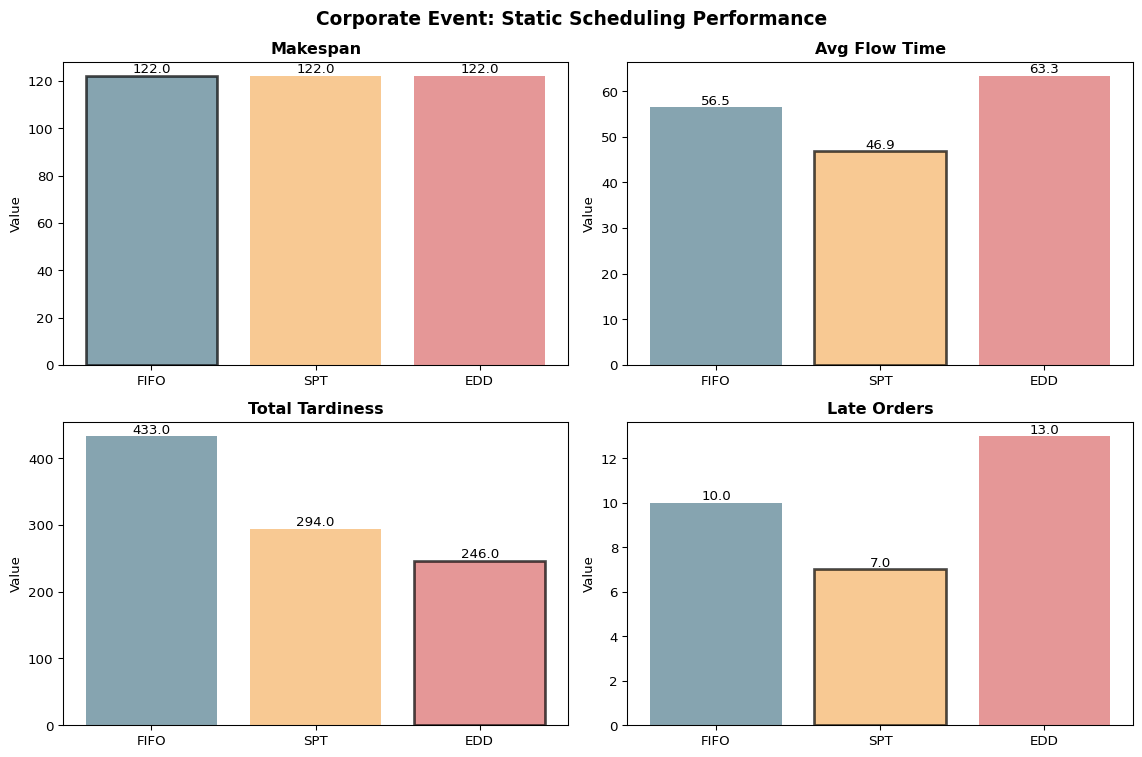

In [16]:
# Create visual comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics_to_plot = ['makespan', 'avg_flow_time', 'total_tardiness', 'late_orders']
colors = ['#537E8F', '#F6B265', '#DB6B6B']

for ax, metric in zip(axes.flat, metrics_to_plot):
    values = [comparison.loc[rule, metric] for rule in ['FIFO', 'SPT', 'EDD']]
    bars = ax.bar(['FIFO', 'SPT', 'EDD'], values, color=colors, alpha=0.7)

    # Highlight the best performer
    best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

    ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Value')

    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom')

plt.suptitle('Corporate Event: Static Scheduling Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Why these results?**

-   **SPT minimizes avg flow time**: Short jobs finish quickly, reducing
    overall wait
-   **EDD minimizes tardiness**: Processing by deadline directly
    optimizes late penalties
-   **FIFO is neutral**: No optimization, just processes in arbitrary
    order
-   **Same makespan**: All schedules do the same work, just in different
    orders

# Section 5 - The Friday Morning Rush Problem

## Why Static Scheduling Isn’t Enough

The corporate event was a **batch problem**, all orders known upfront.
But most real operations face **online problems** where:

-   Orders arrive over time
-   You can’t see future orders
-   You must make decisions with partial information

**Friday morning at Bean Counter** is this type of problem!

## The Friday Scenario

It’s 6 AM Friday. Your flagship store faces:

-   **Orders arriving continuously** over 2 hours
-   **No future visibility** - can’t see orders that haven’t been placed
    yet
-   **Real-time decisions** - when the machine is free, which available
    order should you process?

This requires **dynamic dispatching**: making decisions based only on
orders that have already arrived.

In [17]:
# Generate realistic Friday morning rush orders
# Generate realistic Friday morning rush orders
np.random.seed(2025)
n_orders = 30

friday_orders = []
current_arrival = 0

for i in range(n_orders):
    # Orders arrive with gaps (exponential inter-arrival times)
    if i > 0:
        current_arrival += np.random.exponential(2.0)

    processing = np.random.choice([1,2,3], p=[0.1,0.5, 0.4])

    # Due times are relative to arrival (customers want drinks soon after ordering)
    order_urgency = np.random.choice(['rush', 'normal', 'relaxed'], p=[0.10, 0.40, 0.50])
    if order_urgency == 'rush':
        due = current_arrival + processing + np.random.randint(1, 3)
    elif order_urgency == 'normal':
        due = current_arrival + processing + np.random.randint(4, 6)
    else:
        due = current_arrival + processing + np.random.randint(7, 12)

    friday_orders.append({
        'id': f'F{i+1:02d}',
        'arrival': round(current_arrival, 1),
        'processing': processing,
        'due': round(due, 1)
    })

df_friday = pd.DataFrame(friday_orders)

print("Friday Morning Rush - Flagship Store")
print(f"Total orders: {len(friday_orders)}")
print(f"Arrival span: {df_friday['arrival'].min():.1f} to {df_friday['arrival'].max():.1f} minutes")
print(f"Total processing needed: {df_friday['processing'].sum()} minutes")
print(f"\nFirst 10 orders:")
print(df_friday.head(10)[['id', 'arrival', 'processing', 'due']])

Friday Morning Rush - Flagship Store
Total orders: 30
Arrival span: 0.0 to 61.6 minutes
Total processing needed: 67 minutes

First 10 orders:
    id  arrival  processing   due
0  F01      0.0           2  13.0
1  F02      0.2           3  10.2
2  F03      2.4           2  15.4
3  F04      5.6           1  14.6
4  F05      5.8           2  15.8
5  F06      6.5           2  17.5
6  F07      8.4           3  20.4
7  F08      9.1           2  16.1
8  F09      9.2           2  15.2
9  F10     13.4           1  19.4

## What Happens If We Use Static Scheduling?

Let’s see what goes wrong if we apply static SPT to this dynamic
problem:

In [18]:
# Apply static SPT (sorts all orders, ignores arrivals)
friday_static_spt = schedule_spt_static(friday_orders.copy())
df_friday_static_spt = pd.DataFrame(friday_static_spt)

print("Static SPT on Friday Rush:")
print(df_friday_static_spt.head(10)[['id', 'arrival', 'processing', 'start', 'completion']])
print(f"\nNotice the problem: Order {df_friday_static_spt.iloc[0]['id']} starts at time 0")
print(f"But it doesn't arrive until time {df_friday_static_spt.iloc[0]['arrival']:.1f}!")
print(f"This creates {df_friday_static_spt.iloc[0]['arrival']:.1f} minutes of idle time.")

Static SPT on Friday Rush:
    id  arrival  processing  start  completion
0  F04      5.6           1      0           1
1  F10     13.4           1      1           2
2  F13     23.6           1      2           3
3  F23     46.9           1      3           4
4  F25     48.0           1      4           5
5  F01      0.0           2      5           7
6  F03      2.4           2      7           9
7  F05      5.8           2      9          11
8  F06      6.5           2     11          13
9  F08      9.1           2     13          15

Notice the problem: Order F04 starts at time 0
But it doesn't arrive until time 5.6!
This creates 5.6 minutes of idle time.

> **Warning**
>
> **Static scheduling on online problems creates idle time!**
>
> Static SPT sorts all orders by processing time, then tries to do the
> shortest first. But if that order hasn’t arrived yet, the machine sits
> idle waiting.
>
> We need **dynamic dispatching** that only considers orders that have
> already arrived.

# Section 6 - Dynamic Dispatching

## The Dynamic Dispatching Algorithm

Instead of sorting everything upfront, we make decisions **one at a
time** as the machine becomes free:

1.  Start with `current_time = 0`
2.  **While there are unscheduled orders:**
    -   Find which orders have `arrival <= current_time` (the “available
        pool”)
    -   If no orders available, jump forward to the next arrival
    -   Apply your rule (FIFO/SPT/EDD) to choose from the available pool
    -   Schedule that order, update time, repeat

This simulates real-time decision-making!

## Exercise 6.1 - Implement Dynamic SPT

Implement SPT with dynamic dispatching for Bean Counter.

> **Dynamic Scheduling Logic**
>
> **Key difference from static:** You can only schedule orders that have
> already arrived!
>
> 1.  Use a `while remaining:` loop (not a for loop over pre-sorted
>     list)
> 2.  Filter to `available = [orders where arrival <= current_time]`
> 3.  If no available orders, jump forward:
>     `current_time = min(arrival of remaining)`
> 4.  Then apply SPT to the available pool

> **List Comprehension for Filtering**
>
> **List comprehension** creates a new list based on a condition:
>
> ``` python
> # General pattern
> new_list = [item for item in old_list if condition]
>
> # Example: filter numbers > 5
> numbers = [3, 7, 2, 9, 1, 6]
> big_numbers = [n for n in numbers if n > 5]
> # Result: [7, 9, 6]
>
> # Filter orders by arrival time
> available = [order for order in remaining if order['arrival'] <= current_time]
> ```

In [19]:
# YOUR CODE BELOW
def schedule_spt_dynamic(orders):
    """
    Schedule orders using DYNAMIC Shortest Processing Time
    At each decision point, choose shortest job among those that have arrived
    """
    scheduled = []
    remaining = [o.copy() for o in orders]  # Make copies to avoid modifying originals
    current_time = 0

    while remaining:
        # Find available orders (already arrived)
        # Use list comprehension: [o for o in remaining if ...]
        available = # YOUR CODE: list of orders where arrival <= current_time

        # If nothing available, jump to next arrival
        if not available:
            # Find earliest arrival among remaining orders
            current_time = # YOUR CODE: min arrival time of remaining orders
            # Now re-filter for available orders
            available = # YOUR CODE: update available orders

        # Choose shortest processing time among available
        # Use min() with key=lambda
        next_order = # YOUR CODE: min(available, key=lambda ...)

        # Schedule it
        next_order['start'] = current_time
        next_order['completion'] = current_time + next_order['processing']
        current_time = next_order['completion']

        # Move from remaining to scheduled
        scheduled.append(next_order)
        remaining.remove(next_order)

    return scheduled

# Test dynamic SPT
friday_dynamic_spt = schedule_spt_dynamic(friday_orders)
df_friday_dynamic_spt = pd.DataFrame(friday_dynamic_spt)

In [21]:
# Tests
assert all(df_friday_dynamic_spt['start'] >= df_friday_dynamic_spt['arrival']), \
    "All orders should start at or after their arrival time"

# Calculate idle time for both approaches
static_idle = sum(max(0, row['arrival'] - (df_friday_static_spt.iloc[i-1]['completion'] if i > 0 else 0))
                  for i, row in df_friday_static_spt.iterrows())
dynamic_idle = sum(max(0, row['start'] - (df_friday_dynamic_spt.iloc[i-1]['completion'] if i > 0 else 0))
                   for i, row in df_friday_dynamic_spt.iterrows())

print("Excellent! Dynamic SPT implementation is correct!")
print(f"\nDynamic vs Static SPT on Friday Rush:")
print(f" • Static makespan (with arrival violations!): {df_friday_static_spt['completion'].max():.1f} minutes")
print(f" • Dynamic makespan (no violations): {df_friday_dynamic_spt['completion'].max():.1f} minutes")
print(f" • Change: {df_friday_static_spt['completion'].max() - df_friday_dynamic_spt['completion'].max():.1f} minutes faster")
print(f" • Dynamic idle time: {dynamic_idle:.1f} minutes")

## Exercise 6.2 - Implement Dynamic EDD

Now implement EDD with dynamic dispatching to minimize tardiness in the
Friday rush.

In [22]:
# YOUR CODE BELOW
def schedule_edd_dynamic(orders):
    """
    Schedule orders using DYNAMIC Earliest Due Date
    At each decision point, choose order with earliest deadline among available orders
    """
    scheduled = []
    remaining = [o.copy() for o in orders]
    current_time = 0

    while remaining:
        # YOUR CODE: Find available orders
        available = # [orders where arrival <= current_time]

        # YOUR CODE: Handle no available orders
        if not available:
            current_time = # min arrival of remaining
            available = # update available

        # YOUR CODE: Choose earliest due date
        next_order = # Hint: Just change the key from SPT

        # Schedule it (same as SPT)
        next_order['start'] = current_time
        next_order['completion'] = current_time + next_order['processing']
        current_time = next_order['completion']

        scheduled.append(next_order)
        remaining.remove(next_order)

    return scheduled

# Test dynamic EDD
friday_dynamic_edd = schedule_edd_dynamic(friday_orders)
df_friday_dynamic_edd = pd.DataFrame(friday_dynamic_edd)

In [24]:
# Tests
assert all(df_friday_dynamic_edd['start'] >= df_friday_dynamic_edd['arrival']), \
    "All orders should start at or after arrival"

metrics_dynamic_spt = calculate_metrics(df_friday_dynamic_spt)
metrics_dynamic_edd = calculate_metrics(df_friday_dynamic_edd)

assert metrics_dynamic_edd['total_tardiness'] <= metrics_dynamic_spt['total_tardiness'], \
    "EDD should minimize tardiness better than SPT"

print("✓ Dynamic EDD implementation correct!")
print(f"\nFriday Rush: Dynamic SPT vs Dynamic EDD")
print(f" • SPT avg flow time: {metrics_dynamic_spt['avg_flow_time']:.1f} minutes")
print(f" • EDD avg flow time: {metrics_dynamic_edd['avg_flow_time']:.1f} minutes")
print(f" • SPT total tardiness: {metrics_dynamic_spt['total_tardiness']:.1f} minutes")
print(f" • EDD total tardiness: {metrics_dynamic_edd['total_tardiness']:.1f} minutes")
print(f" • SPT late orders: {metrics_dynamic_spt['late_orders']:.0f}")
print(f" • EDD late orders: {metrics_dynamic_edd['late_orders']:.0f}")

## Final Performance Comparison

Friday Morning Rush - Final Performance:
             makespan  avg_flow_time  total_tardiness  late_orders
Dynamic_SPT      69.1          33.82             20.5          5.0
Dynamic_EDD      69.1          34.18              8.3          6.0

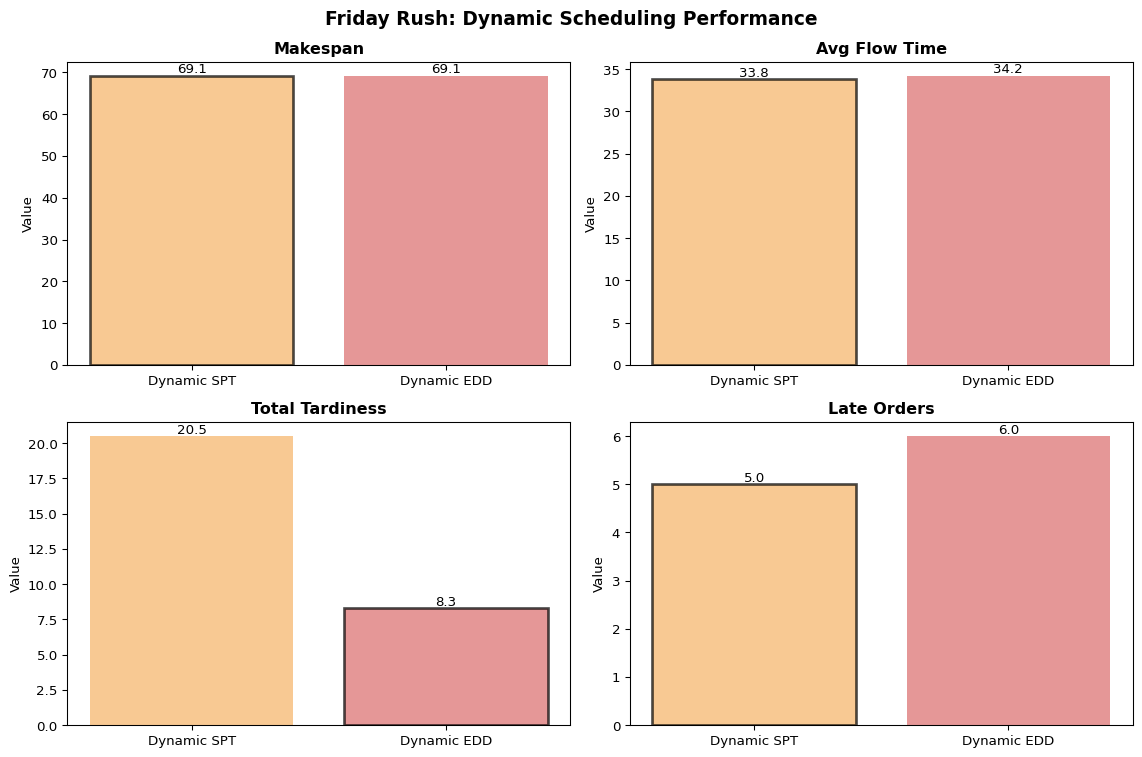

In [25]:
# Calculate metrics for all Friday approaches
friday_comparison = pd.DataFrame({
    'Dynamic_SPT': calculate_metrics(df_friday_dynamic_spt),
    'Dynamic_EDD': calculate_metrics(df_friday_dynamic_edd)
}).T

print("Friday Morning Rush - Final Performance:")
print(friday_comparison.round(2))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics_to_plot = ['makespan', 'avg_flow_time', 'total_tardiness', 'late_orders']
colors = ['#F6B265', '#DB6B6B']

for ax, metric in zip(axes.flat, metrics_to_plot):
    values = [friday_comparison.loc[rule, metric] for rule in ['Dynamic_SPT', 'Dynamic_EDD']]
    bars = ax.bar(['Dynamic SPT', 'Dynamic EDD'], values, color=colors, alpha=0.7)

    best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

    ax.set_title(metric.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylabel('Value')

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom')

plt.suptitle('Friday Rush: Dynamic Scheduling Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Conclusion

**Congratulations!** You’ve mastered both paradigms of scheduling:

## Key Takeaways

1.  **Static Scheduling** (Corporate Event):
    -   All orders known upfront
    -   Sort and sequence optimally
    -   SPT minimizes flow time, EDD minimizes tardiness
    -   Simple to implement and understand
2.  **Dynamic Scheduling** (Friday Rush):
    -   Orders arrive over time
    -   Make real-time decisions with partial information
    -   Only consider orders that have arrived
    -   Better machine utilization, more realistic
3.  **Algorithm Performance**:
    -   **FIFO**: Simple, fair, but not optimized
    -   **SPT**: Minimizes average wait time
    -   **EDD**: Minimizes tardiness and late orders
    -   Choice depends on business priorities!
4.  **When to Use Each**:
    -   Static: Batch processing, complete information, planning ahead
    -   Dynamic: Real-time operations, orders arrive continuously,
        reactive scheduling

## What’s Next?

You’ve now mastered both static and dynamic scheduling approaches! In
the next notebook, you’ll tackle the **Bike Factory Competition** where
you’ll apply these scheduling techniques to a real two-stage
manufacturing problem.

In the following lectures, you’ll then learn advanced techniques like
**local search** and **metaheuristics** that can improve even the best
greedy solutions by intelligently exploring schedule variations.

**Your Bean Counter operations are now optimized for both planning and
real-time scenarios!**